# Adegbehingbe Godwin 

# Problem Statement
Wazobia Real Estate Limited, a leading real estate company in Nigeria, seeks your expertise to tackle one of its crucial challenges. They are determined to provide accurate and competitive pricing for houses, but accurately predicting house prices in the current market has been a hurdle they aim to overcome. Should you accept it, your mission is to develop a powerful and accurate predictive model that can estimate house prices in Nigeria.


Essentially, the company wants —

To create a robust predictive model using the provided dataset.

My task: 
-To analyze various factors that impact house prices identify meaningful patterns, and
-To build a model that can generate reliable price predictions. 

With your data-driven solution, you will empower Wazobia Real Estate Limited to make informed pricing decisions,
enhance its competitiveness in the market,and deliver enhanced value to its customers.



In [108]:
#Import Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import seaborn as sns



from scipy.stats import skew


from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))




# Data Exploration and Preprocessing

In [110]:

# Load Data
train = pd.read_csv('Housing_dataset_train.csv')
test = pd.read_csv('Housing_dataset_test.csv')
sample_sub = pd.read_csv('Sample_submission.csv')

#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['ID']
test_ID = test['ID']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("ID", axis = 1, inplace = True)
test.drop("ID", axis = 1, inplace = True)


The train data size before dropping Id feature is : (14000, 7) 
The test data size before dropping Id feature is : (6000, 6) 


In [111]:
train.head()

,loc,title,bedroom,bathroom,parking_space,price
0,Katsina,Semi-detached duplex,2.000,2.000,1.000,1149999.565
1,Ondo,Apartment,nan,2.000,4.000,1672416.689
2,Ekiti,NaN,7.000,5.000,nan,3364799.814
3,Anambra,Detached duplex,5.000,2.000,4.000,2410306.756
4,Kogi,Terrace duplex,nan,5.000,6.000,2600700.898


In [112]:
#Different kinds of classes in every categorical column
def unique_classes(dataframe):
    """
    Returns a dataframe that contains the categorical values and their numbers.
    
    dataframe: dataframe that gives the column names and their % of missing values
    """
    dataframe = dataframe.select_dtypes('object')
    output = pd.DataFrame(dataframe.apply(pd.Series.nunique))
    output['Categorical values'] = dataframe.select_dtypes('object').apply(pd.Series.nunique).values
    for i in range(dataframe.shape[1]):
        output.iloc[i,1] = str(dataframe.iloc[:,i].unique())
    #pd.set_option('display.max_colwidth', -1)
    return output.rename(columns={0: 'Number Categorical values'})
unique_classes(train)

,Number Categorical values,Categorical values
loc,36,['Katsina' 'Ondo' 'Ekiti' 'Anambra' 'Kogi' 'Borno' 'Kwara' 'Osun' 'Kaduna'\n 'Ogun' 'Bayelsa' nan 'Abia' 'Rivers' 'Taraba' 'Ebonyi' 'Kebbi' 'Enugu'\n 'Edo' 'Nasarawa' 'Delta' 'Kano' 'Yobe' 'Benue' 'Bauchi' 'Cross River'\n 'Niger' 'Adamawa' 'Plateau' 'Imo' 'Oyo' 'Zamfara' 'Sokoto' 'Jigawa'\n 'Gombe' 'Akwa Ibom' 'Lagos']
title,10,['Semi-detached duplex' 'Apartment' nan 'Detached duplex' 'Terrace duplex'\n 'Mansion' 'Bungalow' 'Penthouse' 'Townhouse' 'Flat' 'Cottage']


In [113]:
#Missing values
def missing_columns(dataframe):
    """
    Returns a dataframe that contains missing column names and 
    percent of missing values in relation to the whole dataframe.
    
    dataframe: dataframe that gives the column names and their % of missing values
    """
    
    # find the missing values
    missing_values = dataframe.isnull().sum().sort_values(ascending=False)
    
    # percentage of missing values in relation to the overall size
    missing_values_pct = 100 * missing_values/len(dataframe)
    
    # create a new dataframe which is a concatinated version
    concat_values = pd.concat([missing_values, missing_values/len(dataframe),missing_values_pct.round(1)],axis=1)

    # give new col names
    concat_values.columns = ['Missing Count','Missing Count Ratio','Missing Count %']
    
    # return the required values
    return concat_values[concat_values.iloc[:,1]!=0]

missing_columns(train)

,Missing Count,Missing Count Ratio,Missing Count %
loc,1813,0.130,13.000
parking_space,1811,0.129,12.900
bathroom,1805,0.129,12.900
bedroom,1799,0.129,12.800
title,1722,0.123,12.300


In [114]:
subset=['loc', 'title', 'bedroom', 'bathroom', 'parking_space']
train.fillna(train[subset].median(), inplace=True)
train.fillna({'loc': 'Unknown', 'title': 'Unknown'}, inplace=True)

In [115]:
train.describe()

,bedroom,bathroom,parking_space,price
count,14000.000,14000.000,14000.000,14000.000
mean,4.269,2.988,3.148,2138081.749
std,2.281,1.938,1.493,1083056.665
min,1.000,1.000,1.000,431967.290
25%,3.000,2.000,2.000,1393989.517
50%,4.000,2.000,3.000,1895223.070
75%,6.000,4.000,4.000,2586699.494
max,9.000,7.000,6.000,16568486.160


In [116]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   loc            14000 non-null  object 
 1   title          14000 non-null  object 
 2   bedroom        14000 non-null  float64
 3   bathroom       14000 non-null  float64
 4   parking_space  14000 non-null  float64
 5   price          14000 non-null  float64
dtypes: float64(4), object(2)
memory usage: 656.4+ KB


# Exploratory Data Analysis

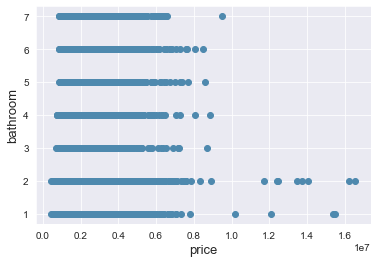

In [117]:
fig, ax = plt.subplots()
ax.scatter(y = train['bathroom'], x = train['price'])
plt.ylabel('bathroom', fontsize=13)
plt.xlabel('price', fontsize=13)
plt.show()

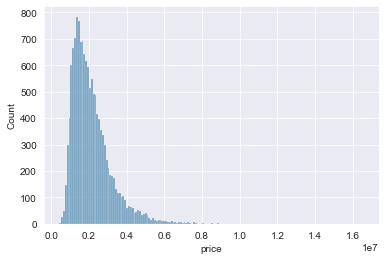

In [118]:
sns.histplot(train['price'])

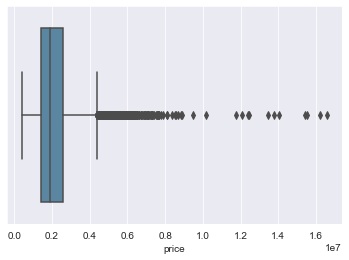

In [119]:
sns.boxplot(train['price'])

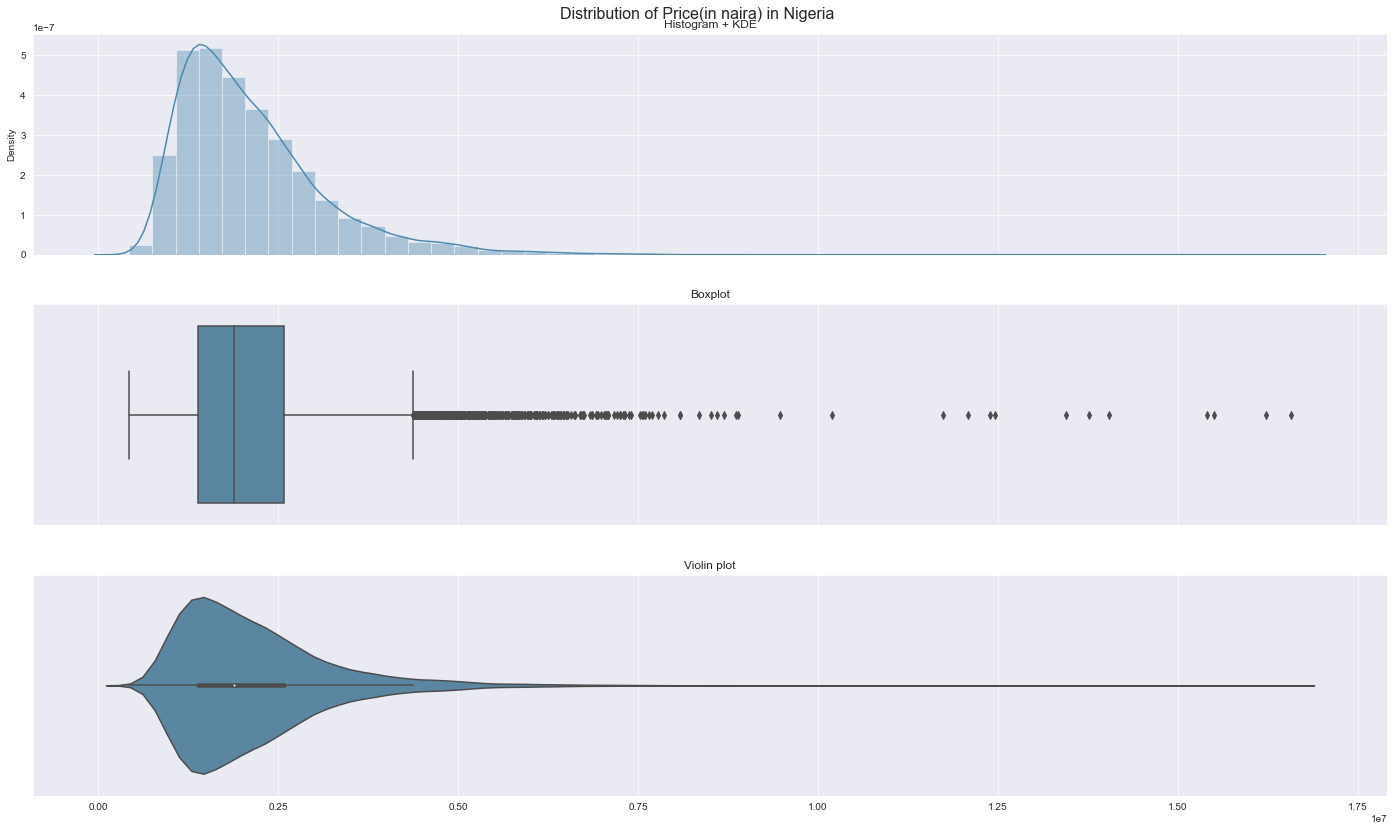

In [151]:
def triple_plot(x, title):
    fig, ax = plt.subplots(3,1,figsize=(20,12),sharex=True)
    sns.distplot(x, ax=ax[0])
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x, ax=ax[1])
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')
    sns.violinplot(x, ax=ax[2])
    ax[2].set(xlabel=None)
    ax[2].set_title('Violin plot')
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(pad=3.0)
    plt.show()
    
triple_plot(train['price'],'Distribution of Price(in naira) in Nigeria')

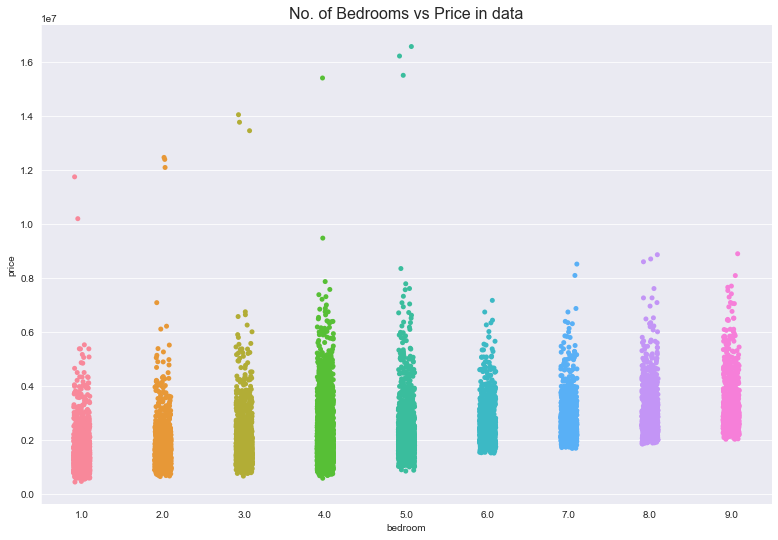

In [149]:
def cat_plot(data,title):
    sns.catplot(x="bedroom", y="price", data=data)
    plt.title('No. of Bedrooms vs Price in '+ title,size=16)
    plt.gcf().set_size_inches(12,8)
    plt.show()
    
cat_plot(train,"data")

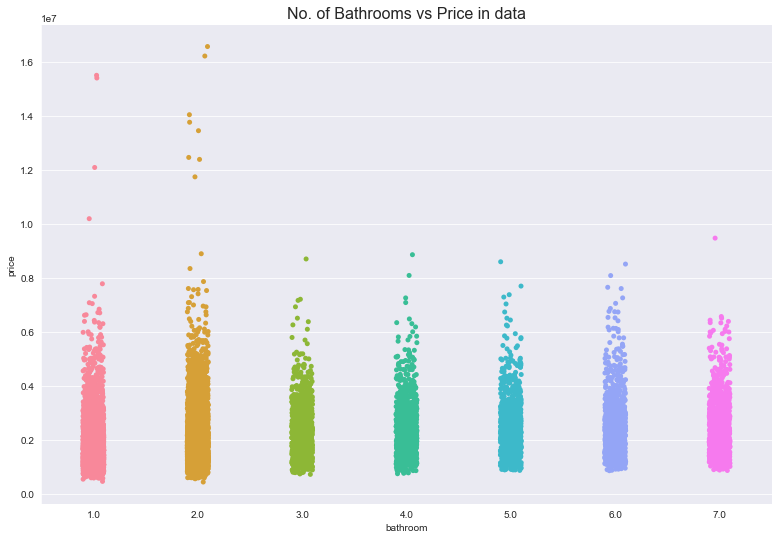

In [152]:
def cat_plot(data,title):
    sns.catplot(x="bathroom", y="price", data=data)
    plt.title('No. of Bathrooms vs Price in '+ title,size=16)
    plt.gcf().set_size_inches(12,8)
    plt.show()
    
cat_plot(train,"data")

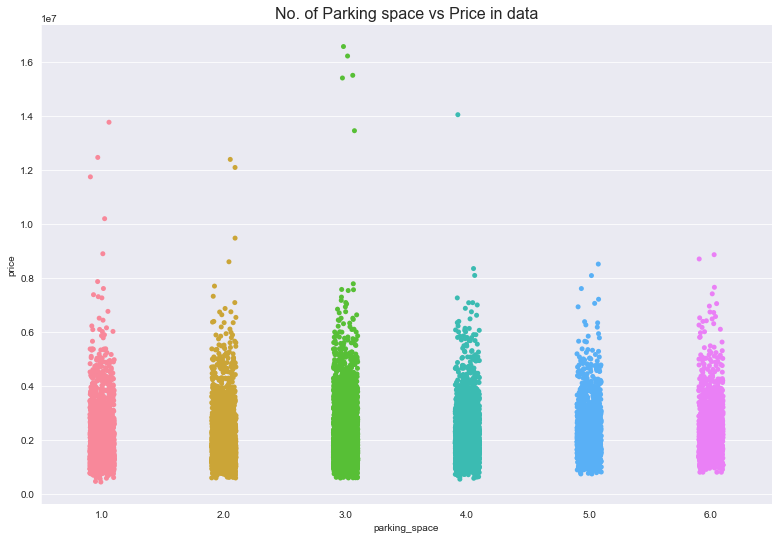

In [153]:
def cat_plot(data,title):
    sns.catplot(x="parking_space", y="price", data=data)
    plt.title('No. of Parking space vs Price in '+ title,size=16)
    plt.gcf().set_size_inches(12,8)
    plt.show()
    
cat_plot(train,"data")

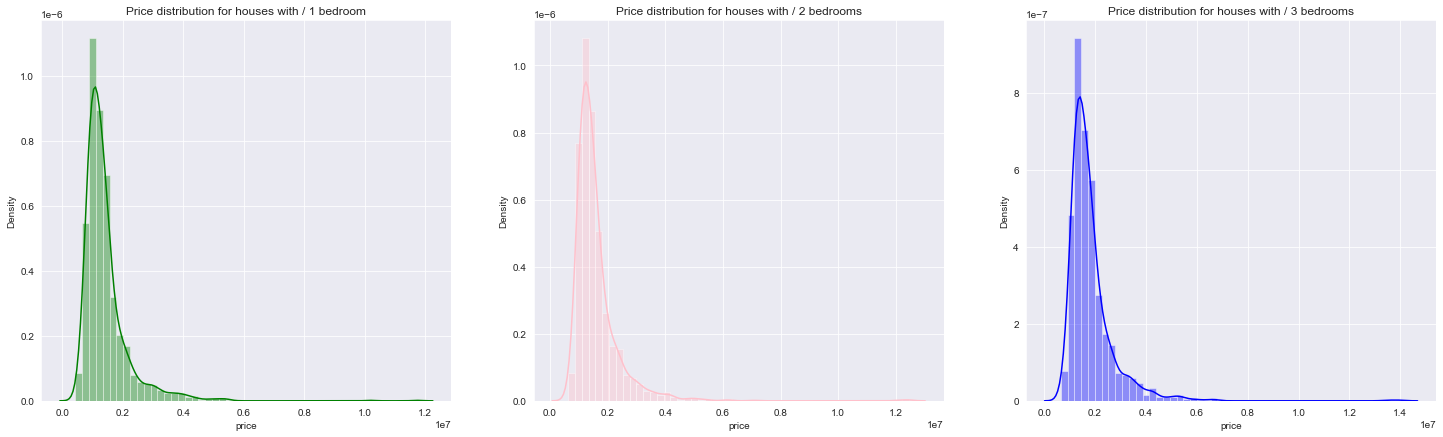

In [124]:
# Distribution of values based on number of bedrooms
fig= plt.figure(figsize=(25,7))

ax=fig.add_subplot(131)
sns.distplot(train[(train.bedroom == 1)]["price"], color='green', ax=ax)
ax.set_title('Price distribution for houses with / 1 bedroom');

ax=fig.add_subplot(132)
sns.distplot(train[(train.bedroom  == 2)]["price"], color='pink', ax=ax)
ax.set_title('Price distribution for houses with / 2 bedrooms');

ax=fig.add_subplot(133)
sns.distplot(train[(train.bedroom  == 3)]["price"], color='blue',ax=ax)
ax.set_title('Price distribution for houses with / 3 bedrooms');

Text(0.5, 1.0, 'Scatter Relating Price to bathrooms')

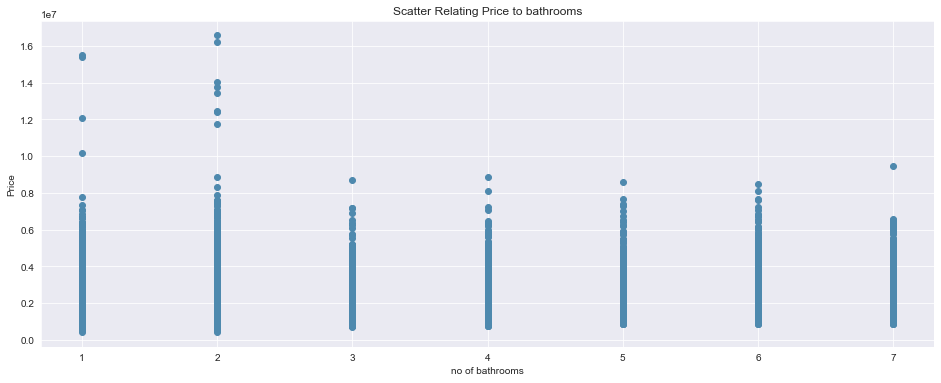

In [125]:
#Plot Scatter Relating SalePrice to Living Area Size
fig, axs = plt.subplots(figsize = (16,6))

axs = plt.scatter(x=train.bathroom, y=train.price)
plt.ylabel('Price')
plt.xlabel('no of bathrooms')
plt.title('Scatter Relating Price to bathrooms')


Text(0.5, 1.0, 'Scatter Relating Price to bedrooms')

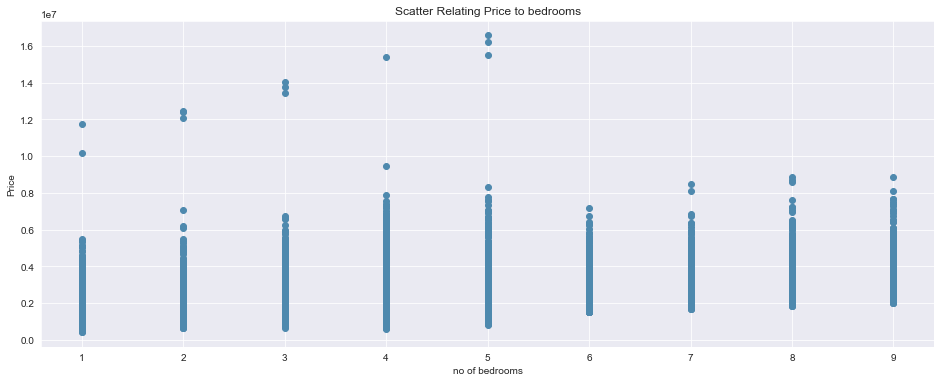

In [126]:
#Plot Scatter Relating SalePrice to Living Area Size
fig, axs = plt.subplots(figsize = (16,6))

axs = plt.scatter(x=train.bedroom, y=train.price)
plt.ylabel('Price')
plt.xlabel('no of bedrooms')
plt.title('Scatter Relating Price to bedrooms')

Text(0.5, 1.0, 'Scatter Relating Price to parking_space')

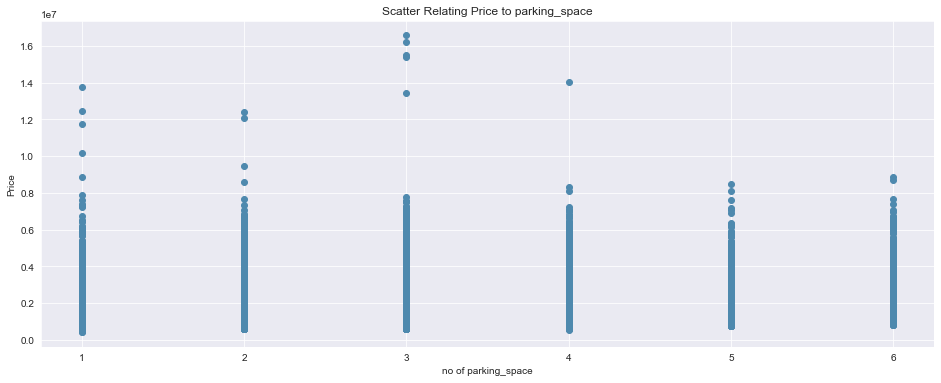

In [127]:
#Plot Scatter Relating SalePrice to Living Area Size
fig, axs = plt.subplots(figsize = (16,6))

axs = plt.scatter(x=train.parking_space, y=train.price)
plt.ylabel('Price')
plt.xlabel('no of parking_space')
plt.title('Scatter Relating Price to parking_space')

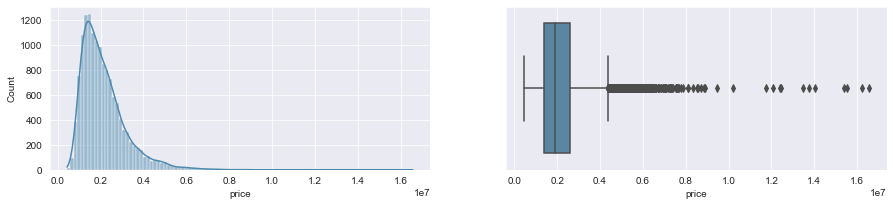

In [128]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2) #create a single row subplot layout with two columns
fig.set_size_inches([15,3]) #adjusts the width and height of the figure
sns.histplot(data=train, x='price', bins=100, kde=True, ax=ax0) #histogram plot based on SalePrice
sns.boxplot(data=train, x="price", ax=ax1); #box plot based on SalePrice

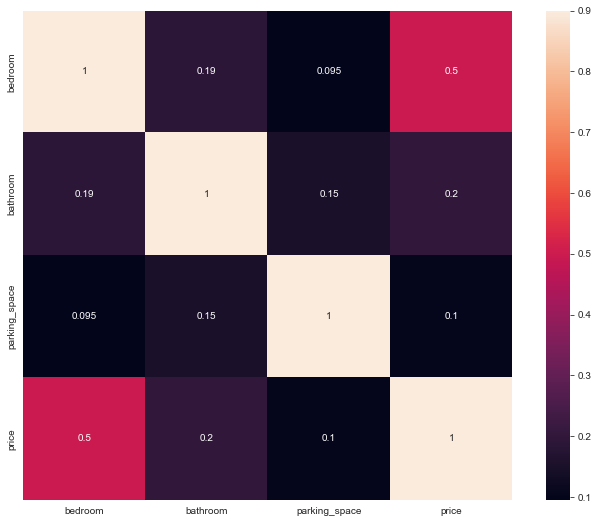

In [129]:

corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, annot=True,square=True)

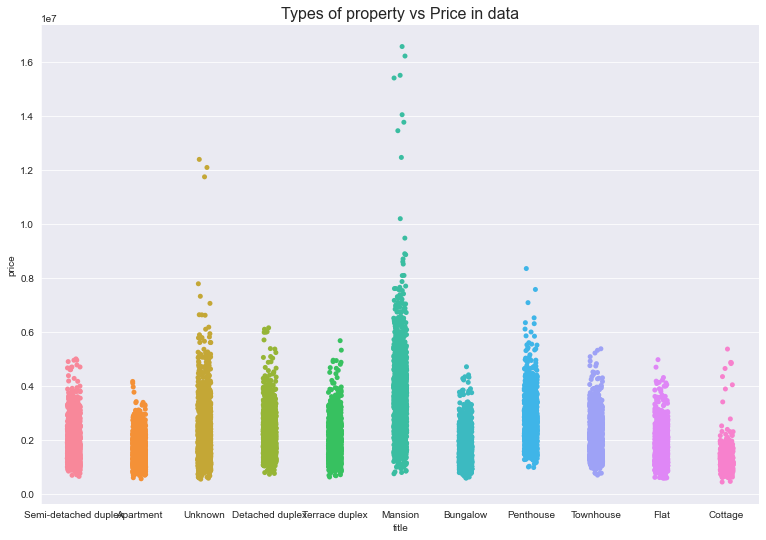

In [155]:
def cat_plot(data,title):
    sns.catplot(x="title", y="price", data=data)
    plt.title('Types of property vs Price in '+ title,size=16)
    plt.gcf().set_size_inches(12,8)
    plt.show()
    
cat_plot(train,"data")

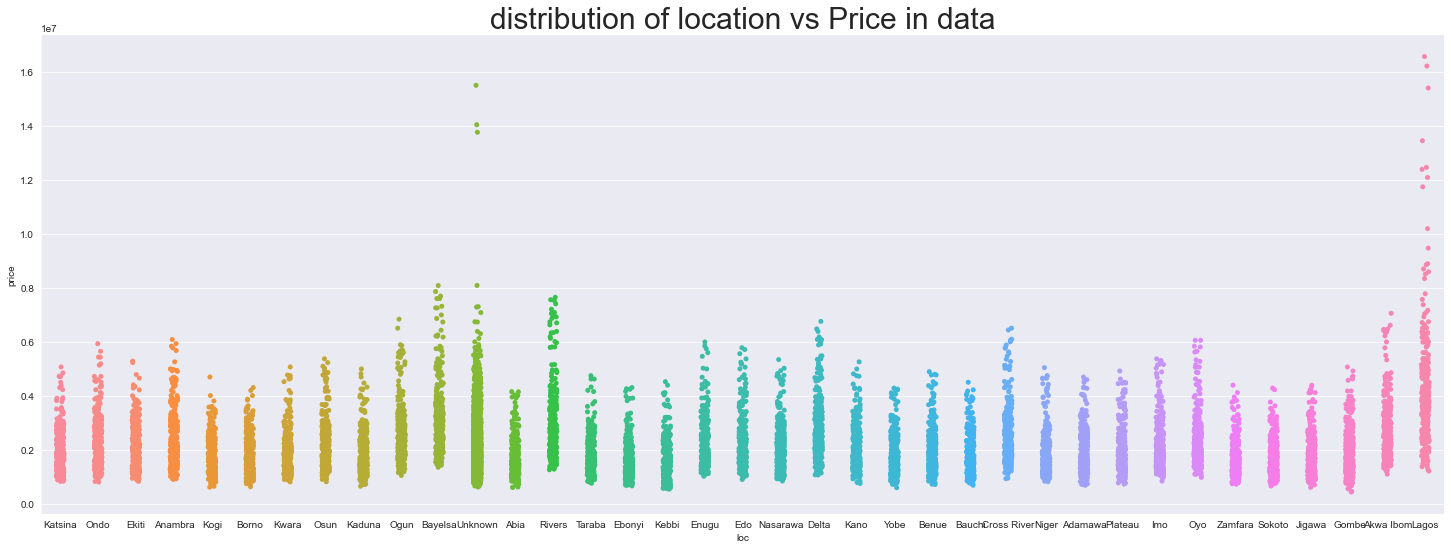

In [156]:
def cat_plot(data,title):
    sns.catplot(x="loc", y="price", data=data)
    plt.title('distribution of location vs Price in '+ title,size=30)
    plt.gcf().set_size_inches(24,8)
    plt.show()
    
cat_plot(train,"data")

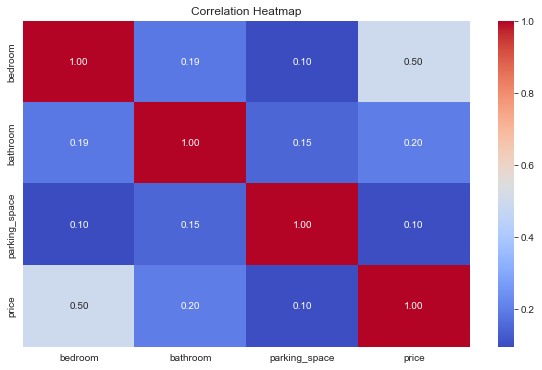

In [137]:
# Correlation heatmap to identify relationships between numerical features
correlation_matrix = train.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()



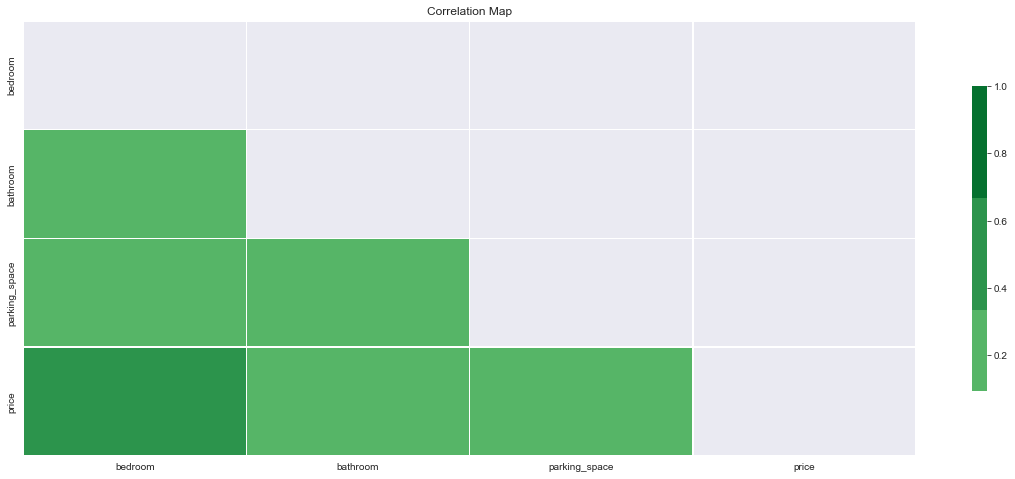

In [132]:
#Visual the correlation matrix
fig, axs = plt.subplots(figsize=(20, 8))
mat = train.corr(method = 'pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
sns.heatmap(mat, mask=mask, cmap = sns.color_palette('Greens'), vmax=1, center=0, annot = False,
             linewidths=.5, cbar_kws={'shrink': .7})
axs.set_title("Correlation Map")
plt.show()

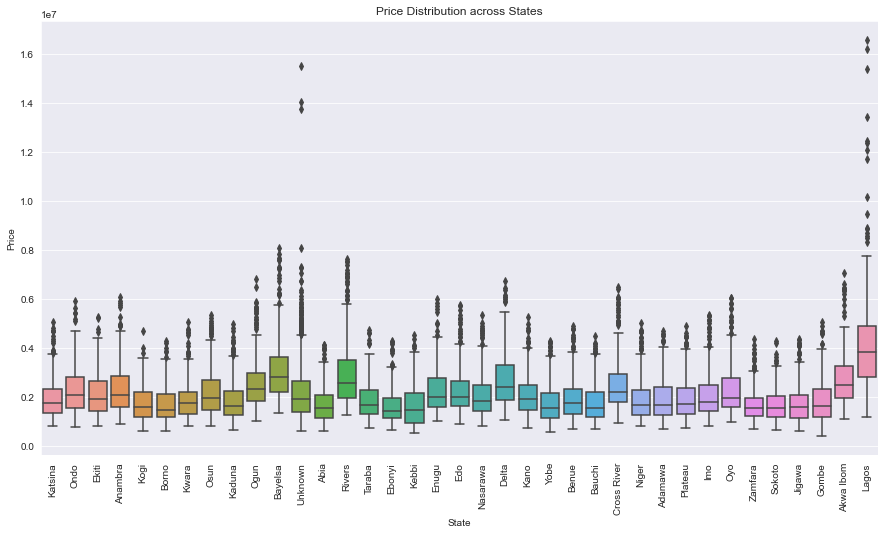

In [133]:
# Box plot for price across different states
plt.figure(figsize=(15, 8))
sns.boxplot(x='loc', y='price', data=train)
plt.xlabel('State')
plt.ylabel('Price')
plt.title('Price Distribution across States')
plt.xticks(rotation=90)
plt.show()

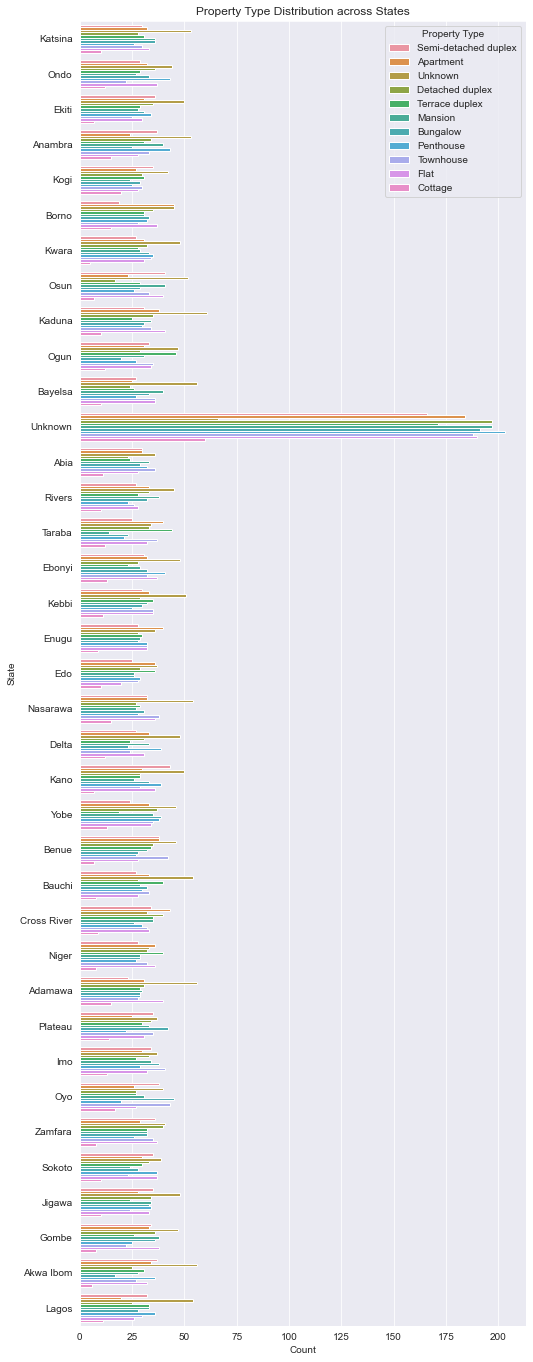

In [138]:
plt.figure(figsize=(8, 24))  # Adjust the figure size for vertical layout
sns.countplot(y='loc', hue='title', data=train)  # Swap x with y for vertical layout
plt.ylabel('State')  # Swap x and y labels accordingly
plt.xlabel('Count')
plt.title('Property Type Distribution across States')
plt.legend(title='Property Type')
plt.show()




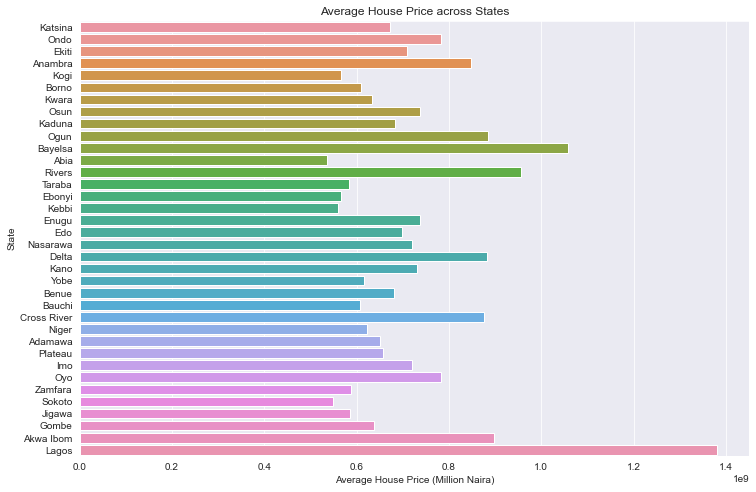

In [142]:
train_filtered = train[train['loc'] != 'Unknown']

plt.figure(figsize=(12, 8))  # Adjust the figure size
sns.barplot(x='price', y='loc', data=train_filtered, ci=None, estimator=sum)
plt.xlabel('Average House Price (Million Naira)')
plt.ylabel('State')
plt.title('Average House Price across States')
plt.show()

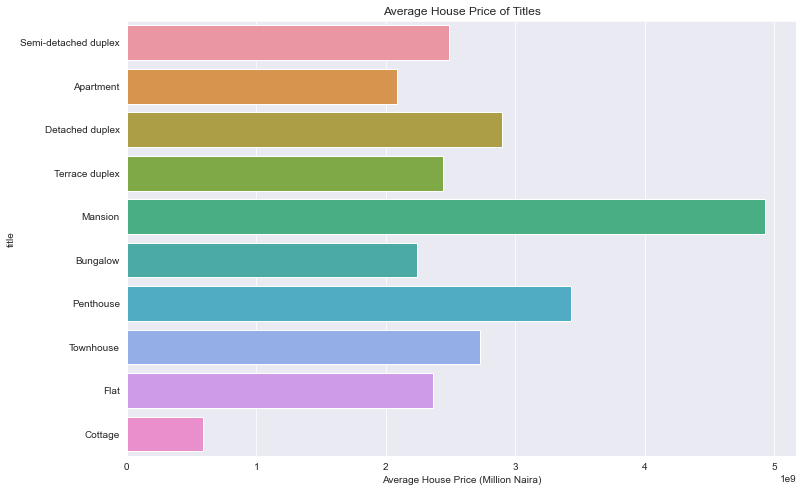

In [157]:
train_filtered = train[train['title'] != 'Unknown']

plt.figure(figsize=(12, 8))  # Adjust the figure size
sns.barplot(x='price', y='title', data=train_filtered, ci=None, estimator=sum)
plt.xlabel('Average House Price (Million Naira)')
plt.ylabel('title')
plt.title('Average House Price of Titles')
plt.show()

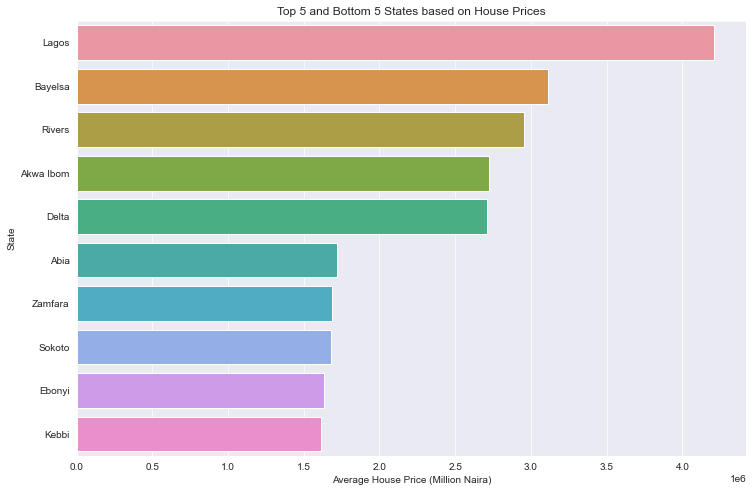

In [143]:

# Calculate the average house price for each state
average_prices = train.groupby('loc')['price'].mean().reset_index()

# Sort the states based on the average house price
sorted_states = average_prices.sort_values(by='price', ascending=False)

# Select the top 5 and bottom 5 states
top_5_states = sorted_states.head(5)
bottom_5_states = sorted_states.tail(5)

# Concatenate the top and bottom states
selected_states = pd.concat([top_5_states, bottom_5_states])

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='price', y='loc', data=selected_states, ci=None)
plt.xlabel('Average House Price (Million Naira)')
plt.ylabel('State')
plt.title('Top 5 and Bottom 5 States based on House Prices')
plt.show()

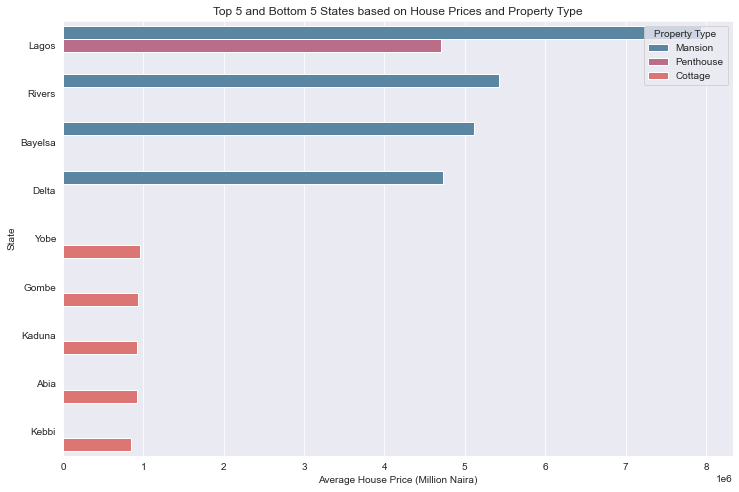

In [144]:
# Calculate the average house price for each combination of 'loc' and 'title'
average_prices = train.groupby(['loc', 'title'])['price'].mean().reset_index()

# Sort the combinations based on the average house price
sorted_states = average_prices.sort_values(by='price', ascending=False)

# Select the top 5 and bottom 5 combinations
top_5_states = sorted_states.head(5)
bottom_5_states = sorted_states.tail(5)

# Concatenate the top and bottom combinations
selected_states = pd.concat([top_5_states, bottom_5_states])

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='price', y='loc', hue='title', data=selected_states, ci=None)
plt.xlabel('Average House Price (Million Naira)')
plt.ylabel('State')
plt.title('Top 5 and Bottom 5 States based on House Prices and Property Type')
plt.legend(title='Property Type')
plt.show()

# Feature Engineering


 mu = 2138081.75 and sigma = 1083017.98



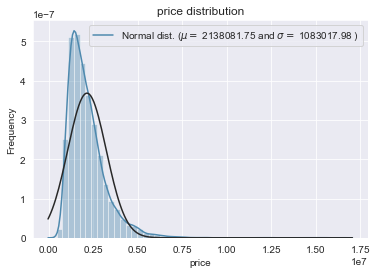

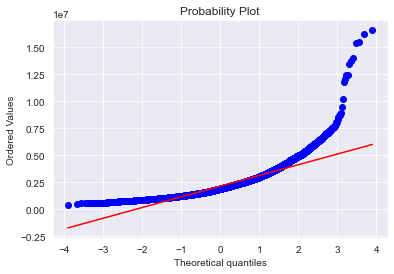

In [97]:
sns.distplot(train['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
plt.show()


 mu = 14.47 and sigma = 0.45



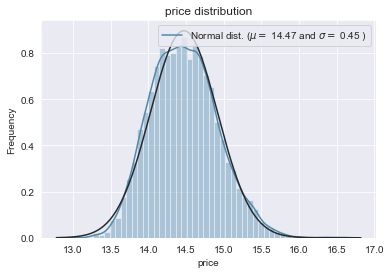

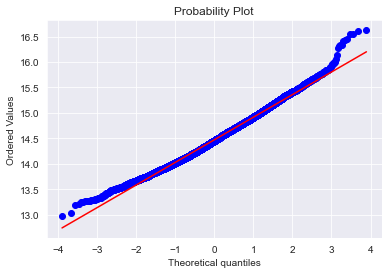

In [98]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["price"] = np.log1p(train["price"])

#Check the new distribution 
sns.distplot(train['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
plt.show()

In [99]:
#Creating Polynomial Features
train["bedroom-s2"] = train["bedroom"] ** 2
train["bedroom-s3"] = train["bedroom"] ** 3
train["bedroom-sq"] = np.sqrt(train["bedroom"])

test["bedroom-s2"] = test["bedroom"] ** 2
test["bedroom-s3"] = test["bedroom"] ** 3
test["bedroom-sq"] = np.sqrt(test["bedroom"])

train["bathroom-s2"] = train["bathroom"] ** 2
train["bathroom-s3"] = train["bathroom"] ** 3
train["bathroom-sq"] = np.sqrt(train["bathroom"])


test["bathroom-s2"] = test["bathroom"] ** 2
test["bathroom-s3"] = test["bathroom"] ** 3
test["bathroom-sq"] = np.sqrt(test["bathroom"])

In [100]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.price.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['price'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (20000, 11)


In [101]:

for col in all_data.select_dtypes(include=['object']):
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[col].values)) 
    all_data[col] = lbl.transform(list(all_data[col].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (20000, 11)


In [102]:
#New Feature 
all_data["total_space"] = all_data["bathroom"]+all_data['parking_space']+all_data['bedroom']

In [103]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
bedroom-s3,1.523
bathroom-s3,1.488
bathroom-s2,1.123
bedroom-s2,1.073
bathroom,0.640
bedroom,0.397
total_space,0.388
bathroom-sq,0.338
parking_space,0.260
loc,-0.040


In [104]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 12 skewed numerical features to Box Cox transform


In [105]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# Modelling

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [ ]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


In [ ]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   
    

averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

In [ ]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))


print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))


In [ ]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['price'] = ensemble
sub.to_csv('subzero.csv',index=False)

In [ ]:
ensemble2 = stacked_pred*0.50 + xgb_pred*0.50

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['price'] = ensemble2
sub.to_csv('subzero4.csv',index=False)